# Titanic

[Data](https://www.openml.org/d/40945) si připravím a potom použiji rozhodovací strom a metodu nejbližších sousedů k predikci, zda pasažéři na Titanicu přežili, nebo ne.

Dataset má následující příznaky:

- ID
- **survived** - 1: pasažér přežil, 0: pasažér nepřežil
- pclass - třída lístku, 1: první třída, 2: druhá třída, 3: třetí třída
- name - jméno pasažéra
- sex - pohlaví
- age - věk v letech
- sibsp - počet sourozenců, manželů/lek na palubě Titanicu
- parch - počet rodičů, dětí na palubě Titanicu
- ticket - číslo lístku
- fare - cena lístku
- cabin - číslo kajuty
- embarked - přístav nalodění, C: Cherbourg, Q: Queenstown, S: Southampton
- home.dest - cílová destinace

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

# Příprava dat

Data načtu, rozdělím a zpracuji. Hodnoty musím převést na číselnou reprezentaci.

In [2]:
data = pd.read_csv("data.csv", sep=",")
display(data.head())
data.info()

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,2,"Baimbrigge, Mr. Charles Robert",male,23.0,0,0,C.A. 31030,10.5000,NaN,S,Guernsey
1,1,0,3,"Aronsson, Mr. Ernst Axel Algot",male,24.0,0,0,349911,7.7750,NaN,S,"Sweden Joliet, IL"
2,2,0,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,NaN,C,NaN
3,3,0,3,"Osen, Mr. Olaf Elon",male,16.0,0,0,7534,9.2167,NaN,S,NaN
4,4,1,2,"Navratil, Master. Michel M",male,3.0,1,1,230080,26.0000,F2,S,"Nice, France"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        796 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       1000 non-null   float64
 10  cabin      225 non-null    object 
 11  embarked   1000 non-null   object 
 12  home.dest  573 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


## Rozdělení dat

Data si rozdělím na trénovací, validační a testovací množinu v poměru 6:2:2. *Survived* je vysvětlovaná proměnná, rovnou ji oddělím. Je typu `int64` a nabývá pouze hodnot 0 a 1, takže s ní nic dělat nemusím. Odteď budu nahlížet jen do trénovací množiny.

In [3]:
Xdata = data.drop("survived", axis=1)
Ydata = data["survived"]

random_seed = 333

Xtrain, Xrest, Ytrain, Yrest = train_test_split(Xdata, Ydata, test_size=0.4, random_state=random_seed)
Xval, Xtest, Yval, Ytest = train_test_split(Xrest, Yrest, test_size=0.5, random_state=random_seed)

display(Xtrain.head())
display(Xtrain.info())
display(Xtrain.describe())
display(Xtrain.nunique())

,ID,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
468,468,3,"Healy, Miss. Hanora ""Nora""",female,NaN,0,0,370375,7.7500,NaN,Q,NaN
314,314,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,S,"New York, NY / Stamford CT"
881,881,2,"Jenkin, Mr. Stephen Curnow",male,32.0,0,0,C.A. 33111,10.5000,NaN,S,"St Ives, Cornwall / Houghton, MI"
705,705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,NaN
231,231,3,"Smith, Mr. Thomas",male,NaN,0,0,384461,7.7500,NaN,Q,NaN


<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 468 to 780
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         600 non-null    int64  
 1   pclass     600 non-null    int64  
 2   name       600 non-null    object 
 3   sex        600 non-null    object 
 4   age        473 non-null    float64
 5   sibsp      600 non-null    int64  
 6   parch      600 non-null    int64  
 7   ticket     600 non-null    object 
 8   fare       600 non-null    float64
 9   cabin      140 non-null    object 
 10  embarked   600 non-null    object 
 11  home.dest  351 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 60.9+ KB


None

,ID,pclass,age,sibsp,parch,fare
count,600.000000,600.000000,473.000000,600.000000,600.000000,600.000000
mean,506.426667,2.296667,29.578224,0.543333,0.368333,33.537597
std,285.507932,0.838547,14.520331,1.087855,0.824903,52.394103
min,0.000000,1.000000,0.750000,0.000000,0.000000,0.000000
25%,268.750000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,512.500000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,760.500000,3.000000,37.000000,1.000000,0.000000,31.275000
max,999.000000,3.000000,80.000000,8.000000,9.000000,512.329200


ID           600
pclass         3
name         598
sex            2
age           80
sibsp          7
parch          7
ticket       495
fare         206
cabin        114
embarked       3
home.dest    223
dtype: int64

## Příznaky

### Příznak *ID*

*ID* obsahuje 600 unikátních hodnot, stejně jako je záznamů v trénovací množině, jedná se o pouze o unikátní identifikátor. Predikovat podle *ID* nemá moc smysl, takže ho použiju jako index dataframu.

In [4]:
print("Počet záznamů:", Xtrain.shape[0])
print("Unikátních ID:", Xtrain["ID"].nunique())

Xtrain = Xtrain.set_index("ID", verify_integrity=True)
Xval = Xval.set_index("ID", verify_integrity=True)
Xtest = Xtest.set_index("ID", verify_integrity=True)

Xtrain.head()

Počet záznamů: 600
Unikátních ID: 600


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
ID,,,,,,,,,,,
468,3,"Healy, Miss. Hanora ""Nora""",female,NaN,0,0,370375,7.7500,NaN,Q,NaN
314,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,35.0,1,0,19943,90.0000,C93,S,"New York, NY / Stamford CT"
881,2,"Jenkin, Mr. Stephen Curnow",male,32.0,0,0,C.A. 33111,10.5000,NaN,S,"St Ives, Cornwall / Houghton, MI"
705,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,NaN,S,NaN
231,3,"Smith, Mr. Thomas",male,NaN,0,0,384461,7.7500,NaN,Q,NaN


### Příznak *pclass*

*Pclass* je typu `int64` a říká nám třídu lístku (první, druhá, třetí). Třídy mají pořadí (ordinální příznak), takže příznak nechám beze změny.

### Příznak *name*

Tento příznak nese jména pasažérů. Jméno nejspíše nebude mít vliv na přežití, takže se příznaku zbavím.

In [5]:
Xtrain = Xtrain.drop("name", axis=1)
Xval = Xval.drop("name", axis=1)
Xtest = Xtest.drop("name", axis=1)

Xtrain.head()

,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
ID,,,,,,,,,,
468,3,female,NaN,0,0,370375,7.7500,NaN,Q,NaN
314,1,female,35.0,1,0,19943,90.0000,C93,S,"New York, NY / Stamford CT"
881,2,male,32.0,0,0,C.A. 33111,10.5000,NaN,S,"St Ives, Cornwall / Houghton, MI"
705,3,male,26.0,1,0,350025,7.8542,NaN,S,NaN
231,3,male,NaN,0,0,384461,7.7500,NaN,Q,NaN


### Příznak *sex*

*Sex* je typu `object`, ale nabývá jen dvou hodnot: "male" a "female". Nese informaci o pohlaví pasažéra. Přetypuji ho na `category` a pak převedu na číselnou reprezentaci. Jelikož je to binární příznak, nemusím používat one-hot encoding, ale bude stačit `cat.codes`.

In [6]:
display(Xtrain["sex"].unique())
print()

Xtrain["sex"] = Xtrain["sex"].astype("category")
categories_sex = Xtrain["sex"].dtype
Xval["sex"] = Xval["sex"].astype(categories_sex)
Xtest["sex"] = Xtest["sex"].astype(categories_sex)

Xtrain["sex"] = Xtrain["sex"].cat.codes
Xval["sex"] = Xval["sex"].cat.codes
Xtest["sex"] = Xtest["sex"].cat.codes

Xtrain.info()

array(['female', 'male'], dtype=object)


<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 468 to 780
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     600 non-null    int64  
 1   sex        600 non-null    int8   
 2   age        473 non-null    float64
 3   sibsp      600 non-null    int64  
 4   parch      600 non-null    int64  
 5   ticket     600 non-null    object 
 6   fare       600 non-null    float64
 7   cabin      140 non-null    object 
 8   embarked   600 non-null    object 
 9   home.dest  351 non-null    object 
dtypes: float64(2), int64(3), int8(1), object(4)
memory usage: 47.5+ KB


### Příznak *age*

*Age* je věk pasažérů, je typu `float64`. Chybějící hodnoty nahradím průměrem z trénovací množiny.

In [7]:
average_age = Xtrain["age"].mean()
Xtrain["age"] = Xtrain["age"].fillna(average_age)
Xval["age"] = Xval["age"].fillna(average_age)
Xtest["age"] = Xtest["age"].fillna(average_age)

### Příznaky *sibsp* a *parch*

Oba příznaky jsou typu `int64` a říkají nám počet rodinných příslušníků stejné generace (*sibsp*) a jiné generace (*parch*) na palubě. Oba příznaky nechám beze změny.

### Příznaky *ticket* a *fare*

*Ticket* je číslo lodního lístku, to nám nejspíš nic neřekne, tak se ho zbavím. Zato *fare* je cena lodního lístku a ta už roli hrát může. Je typu `float64` a nechám ji beze změny.

In [8]:
Xtrain = Xtrain.drop("ticket", axis=1)
Xval = Xval.drop("ticket", axis=1)
Xtest = Xtest.drop("ticket", axis=1)

### Příznaky *cabin*, *home.dest* a *embarked*

*Cabin* je číslo kajuty, *home.dest* je cílová destinace/bydliště a *embarked* je místo nalodění pasažéra. Všech tří příznaků se zbavím.

In [9]:
Xtrain = Xtrain.drop(["cabin", "home.dest", "embarked"], axis=1)
Xval = Xval.drop(["cabin", "home.dest", "embarked"], axis=1)
Xtest = Xtest.drop(["cabin", "home.dest", "embarked"], axis=1)

Zbylo mi šest příznaků, podle kterých budou modely predikovat.

In [10]:
display(Xtrain.head())
Xtrain.info()

,pclass,sex,age,sibsp,parch,fare
ID,,,,,,
468,3,0,29.578224,0,0,7.7500
314,1,0,35.000000,1,0,90.0000
881,2,1,32.000000,0,0,10.5000
705,3,1,26.000000,1,0,7.8542
231,3,1,29.578224,0,0,7.7500


<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 468 to 780
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  600 non-null    int64  
 1   sex     600 non-null    int8   
 2   age     600 non-null    float64
 3   sibsp   600 non-null    int64  
 4   parch   600 non-null    int64  
 5   fare    600 non-null    float64
dtypes: float64(2), int64(3), int8(1)
memory usage: 28.7 KB


# Rozhodovací strom

Rozhodovací strom je vhodný, protože dokáže pracovat s numerickými i kategorickými příznaky a nevyžaduje normalizaci dat. Je ale náchylný na přeučení, tomu se pokusím zabránit laděním následujících hyperparametrů:

* max_depth - maximální hloubka stromu
* criterion - zda se kvalita rozdělení dat v listu hodnotí podle entropie, nebo gini indexu
* min_samples_split - minimální počet vzorků v listu, aby se ještě rozděloval dál
* min_samples_leaf - minimální počet vzorků, které musí být v listu

Nejlepší model vyberu podle validační přesnosti.

In [11]:
param_gridDT = {
    "max_depth": range(1, 15),
    "criterion": ["entropy", "gini"],
    "min_samples_split": range(2, 15),
    "min_samples_leaf": range(1, 15),
}
param_combDT = ParameterGrid(param_gridDT)

val_acc = []
for params in param_combDT:
    clfDT = DecisionTreeClassifier(**params, random_state=random_seed)
    clfDT.fit(Xtrain, Ytrain)
    val_acc.append(metrics.accuracy_score(Yval, clfDT.predict(Xval)))
best_paramsDT = param_combDT[np.argmax(val_acc)]
display(best_paramsDT)

{'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_depth': 6,
 'criterion': 'entropy'}

In [12]:
clfDT = DecisionTreeClassifier(**best_paramsDT, random_state=random_seed)
clfDT.fit(Xtrain, Ytrain)
print("Rozhodovací strom")
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfDT.predict(Xtrain)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfDT.predict(Xval)):.4f}")
print(f"Validation F1 score: {metrics.f1_score(Yval, clfDT.predict(Xval)):.4f}")

Rozhodovací strom
Train accuracy: 0.8283
Validation accuracy: 0.8650
Validation F1 score: 0.8029


Nejlepší kombinace hyperparametrů má validační přesnost 86.5 % a F1 skóre 0.8029, jde o hodnoty hyperparametrů:

* min_samples_split: 2
* min_samples_leaf: 6
* max_depth: 6
* criterion: entropy

Ještě nakreslím ROC křivku a spočítám AUC.

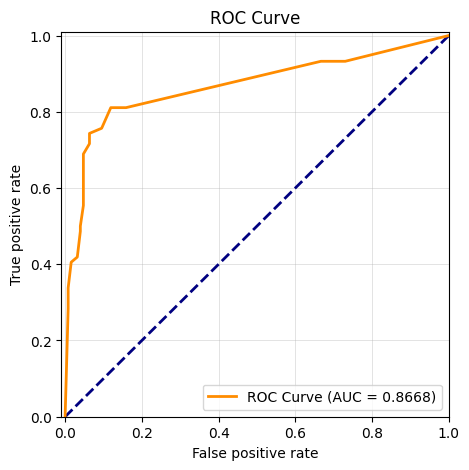

In [13]:
Yval_pred_probaDT = clfDT.predict_proba(Xval)
fpr, tpr, thresholds = metrics.roc_curve(Yval, Yval_pred_probaDT[:, 1])
auc = metrics.roc_auc_score(Yval, Yval_pred_probaDT[:, 1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {auc:.4f})")
ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.grid(linewidth=0.5, alpha=0.5)
ax.set_title("ROC Curve")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.legend(loc="lower right");

# Metoda nejbližších sousedů (KNN)

KNN mohou dělat problém kombinace numerických a kategorických příznaků. Bez normalizace dat by vysoké hodnoty numerických příznaků (např. *age*, *fare*) převážily nízké hodnoty kategorických příznaků (např. *sex*), na které by potom byl brán malý ohled. Proto vyzkouším min-max normalizaci i standardizaci a mezi nimi vyberu lepší model podle validační přesnosti. Budu ladit následující hyperparametry:

* n_neighbors - počet nejbližších sousedů, které brát v úvahu
* weights - zda mají bližší sousedi větší váhu, nebo ne
* p - eukleidovská, nebo manhattanská vzdálenost

## Min-max normalizace

Nejprve provedu min-max normalizaci, musím dávat pozor, abych validační a testovací množinu transformoval stejně jako trénovací.

In [14]:
param_gridKNN = {
    "n_neighbors": range(1, 40),
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}
param_combKNN = ParameterGrid(param_gridKNN)

# min-max normalizace
scaler = MinMaxScaler()
Xtrain_minmax = Xtrain.copy()
Xval_minmax = Xval.copy()
Xtest_minmax = Xtest.copy()
Xtrain_minmax = scaler.fit_transform(Xtrain_minmax)
Xval_minmax = scaler.transform(Xval_minmax)
Xtest_minmax = scaler.transform(Xtest_minmax)

val_acc = []
for params in param_combKNN:
    clfKNN_minmax = KNeighborsClassifier(**params)
    clfKNN_minmax.fit(Xtrain_minmax, Ytrain)
    val_acc.append(metrics.accuracy_score(Yval, clfKNN_minmax.predict(Xval_minmax)))
best_paramsKNN_minmax = param_combKNN[np.argmax(val_acc)]
display(best_paramsKNN_minmax)

{'weights': 'uniform', 'p': 2, 'n_neighbors': 33}

In [15]:
clfKNN_minmax = KNeighborsClassifier(**best_paramsKNN_minmax)
clfKNN_minmax.fit(Xtrain_minmax, Ytrain)
print("KNN (Min-max normalizace)")
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfKNN_minmax.predict(Xtrain_minmax)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfKNN_minmax.predict(Xval_minmax)):.4f}")
print(f"Validation F1 score: {metrics.f1_score(Yval, clfKNN_minmax.predict(Xval_minmax)):.4f}")

KNN (Min-max normalizace)
Train accuracy: 0.7717
Validation accuracy: 0.8400
Validation F1 score: 0.7500


Nejlepší kombinace hyperparametrů má validační přesnost 84 % a F1 skóre 0.75. Hodnoty hyperparametrů jsou:

* weights: uniform
* p: 2
* n_neighbors: 33

Ještě vyzkouším standardizaci.

## Standardizace

Opět si musím dát pozor, abych všechny tři množiny transformoval stejným způsobem. Kromě toho ještě nebudu transformovat binární příznak *sex*, který nabývá jen hodnot 0 a 1. Mohl by ztratit svůj význam.

In [16]:
# standardizace beze zmeny binarnich priznaku (sex)
scaler = StandardScaler()
cols = Xtrain.columns.difference(["sex"], sort=False)

Xtrain_standard = Xtrain.copy()
Xval_standard = Xval.copy()
Xtest_standard = Xtest.copy()
Xtrain_standard[cols] = scaler.fit_transform(Xtrain_standard[cols])
Xval_standard[cols] = scaler.transform(Xval_standard[cols])
Xtest_standard[cols] = scaler.transform(Xtest_standard[cols])

val_acc = []
for params in param_combKNN:
    clfKNN_std = KNeighborsClassifier(**params)
    clfKNN_std.fit(Xtrain_standard, Ytrain)
    val_acc.append(metrics.accuracy_score(Yval, clfKNN_std.predict(Xval_standard)))
best_paramsKNN_std = param_combKNN[np.argmax(val_acc)]
display(best_paramsKNN_std)

{'weights': 'uniform', 'p': 1, 'n_neighbors': 27}

In [17]:
clfKNN_std = KNeighborsClassifier(**best_paramsKNN_std)
clfKNN_std.fit(Xtrain_standard, Ytrain)
print("KNN (Standardizace)")
print(f"Train accuracy: {metrics.accuracy_score(Ytrain, clfKNN_std.predict(Xtrain_standard)):.4f}")
print(f"Validation accuracy: {metrics.accuracy_score(Yval, clfKNN_std.predict(Xval_standard)):.4f}")
print(f"Val F1 score: {metrics.f1_score(Yval, clfKNN_std.predict(Xval_standard)):.4f}")

KNN (Standardizace)
Train accuracy: 0.7917
Validation accuracy: 0.8400
Val F1 score: 0.7647


Nejlepší kombinace hyperparametrů má validační přesnost 84 % a F1 skóre 0.7647. Hyperparametry mají hodnoty:

* weights: uniform
* p: 1
* n_neighbors: 27

Validační přesnost mají min-max normalizace a standardizace stejnou (84 %), ale F1 skóre má lepší standardizace. Takže AUC spočtu a ROC křivku nakreslím pro model využívající standardizaci.

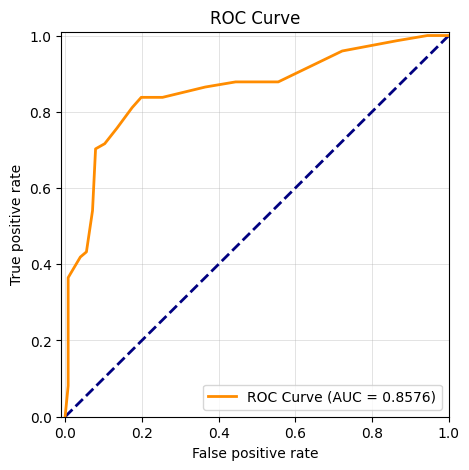

In [18]:
Yval_pred_probaKNN = clfKNN_std.predict_proba(Xval_standard)
fpr, tpr, thresholds = metrics.roc_curve(Yval, Yval_pred_probaKNN[:, 1])
auc = metrics.roc_auc_score(Yval, Yval_pred_probaKNN[:, 1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {auc:.4f})")
ax.set_xlim([-0.01, 1])
ax.set_ylim([0, 1.01])
ax.grid(linewidth=0.5, alpha=0.5)
ax.set_title("ROC Curve")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.legend(loc="lower right");

# Finální model

Rozhodovací strom má přesnost na validační množině 86.5 %, KNN 84 %. Můj finální model proto bude rozhodovací strom s následujícími hyperparametry:

* min_samples_split: 2
* min_samples_leaf: 6
* max_depth: 6
* criterion: entropy

Pomocí testovací množiny, kterou model zatím neviděl, odhadnu přesnost na nových datech a potom pomocí tohoto modelu určím hodnoty příznaku *survived* pro data z `evaluation.csv`.

In [19]:
print("Odhad přesnosti na nových datech:", metrics.accuracy_score(Ytest, clfDT.predict(Xtest)))

Odhad přesnosti na nových datech: 0.83


Načtu si data z `evaluation.csv` a zpracuji ji stejně jako trénovací, validační a testovací množinu.

In [20]:
Xeval = pd.read_csv("evaluation.csv")
Xeval = Xeval.set_index("ID", verify_integrity=True)
Xeval = Xeval.drop(["name", "ticket", "cabin", "embarked", "home.dest"], axis=1)
Xeval["sex"] = Xeval["sex"].astype(categories_sex)
Xeval["sex"] = Xeval["sex"].cat.codes
Xeval["age"] = Xeval["age"].fillna(average_age)
Xeval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 1000 to 1308
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  309 non-null    int64  
 1   sex     309 non-null    int8   
 2   age     309 non-null    float64
 3   sibsp   309 non-null    int64  
 4   parch   309 non-null    int64  
 5   fare    308 non-null    float64
dtypes: float64(2), int64(3), int8(1)
memory usage: 14.8 KB


Vidím, že ve sloupci *fare* je jedna chybějící hodnota. Nahradím ji průměrem z trénovací množiny.

In [21]:
average_fare = Xtrain["fare"].mean()
Xeval["fare"] = Xeval["fare"].fillna(average_fare)

Xeval.info()
Xeval

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 1000 to 1308
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pclass  309 non-null    int64  
 1   sex     309 non-null    int8   
 2   age     309 non-null    float64
 3   sibsp   309 non-null    int64  
 4   parch   309 non-null    int64  
 5   fare    309 non-null    float64
dtypes: float64(2), int64(3), int8(1)
memory usage: 14.8 KB


,pclass,sex,age,sibsp,parch,fare
ID,,,,,,
1000,2,1,19.000000,0,0,10.500000
1001,2,1,32.000000,1,0,26.000000
1002,3,1,60.500000,0,0,33.537597
1003,2,0,48.000000,1,2,65.000000
1004,1,1,29.578224,0,0,39.600000
...,...,...,...,...,...,...
1304,1,1,48.000000,1,0,76.729200
1305,2,1,34.000000,0,0,13.000000
1306,1,0,58.000000,0,0,146.520800


Provedu predikci a výsledek uložím do `results.csv`.

In [22]:
Yeval_pred = clfDT.predict(Xeval)
results_df = pd.DataFrame({"survived": Yeval_pred}, index=Xeval.index)
results_df.to_csv("results.csv")
results_df

,survived
ID,
1000,0
1001,0
1002,0
1003,1
1004,0
...,...
1304,1
1305,0
1306,1


# Závěr

Dataset jsem si připravil, abych pomocí rozhodovacího stromu a metody nejbližších sousedů mohl predikovat, zda pasažéři přežili. Nejlépe dopadl rozhodovací strom, tak jsem si ho zvolil jako finální model a predikci dat z `evaluation.csv` provedl pomocí něj.